In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import os
import os.path as path
import seaborn as sns
from tqdm import tqdm
import re

import theano
import pymc3 as pm
from pymc3.model_graph import ModelGraph, model_to_graphviz
from pymc3 import glm

import matplotlib.image as mpimg


sns.reset_orig()

%matplotlib inline
%load_ext autoreload

%autoreload 2
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams["font.size"] = "24"
sns.set(font_scale=1.5)

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

In [2]:
DATAPATH = 'EEVEE-data.pkl'

In [3]:
def summary(trace, varnames=None):
    pm.plot_posterior(trace, varnames=varnames)
    plt.show()
    pm.plots.traceplot(trace, varnames=varnames)
    plt.show()
    pm.plots.forestplot(trace, varnames=varnames)
    plt.show()
    if varnames is None:
        pm.plots.energyplot(trace)
        plt.show()
        print('Gelman-Rubin ', max(np.max(gr_values) for gr_values in pm.gelman_rubin(trace).values()))
    return pm.summary(trace, varnames=varnames)

In [105]:
def domaine_to_int(x):
    if x is None:
        return 0
    else:
        return int(x)

In [107]:
df = pd.read_pickle(DATAPATH)
df[('ProfilJeuxVideo', 'travaillez_vous_dans_le_domaine_cb_de_temps')] = df[('ProfilJeuxVideo', 'travaillez_vous_dans_le_domaine_cb_de_temps')].apply(domaine_to_int)

In [5]:
participants = np.sort(df.participant.unique())
num_participant = len(df.participant.unique())

avatars = np.sort(df.avatar.unique())
num_avatar = len(df.avatar.unique())

# Statistics

In [74]:
numeric = list(df.mean().index)
non_numeric = [x for x in df.columns if x not in numeric]

In [114]:
df.sort_values(['participant', 'trial'])

trial   age  genre                              get_time  \
                                                              
0      1  30.0  100.0   [2018, 7, 19, 13, 5, 22, 3, 200, 0]   
11     2  75.0   72.0   [2018, 7, 19, 13, 5, 59, 3, 200, 0]   
22     3  70.0    6.0   [2018, 7, 19, 13, 6, 26, 3, 200, 0]   
33     4  45.0   16.0   [2018, 7, 19, 13, 6, 47, 3, 200, 0]   
44     5  20.0  100.0   [2018, 7, 19, 13, 7, 23, 3, 200, 0]   
55     6  32.0   96.0    [2018, 7, 19, 13, 8, 1, 3, 200, 0]   
61     7  65.0   78.0   [2018, 7, 19, 13, 8, 29, 3, 200, 0]   
62     8  33.0   24.0   [2018, 7, 19, 13, 8, 45, 3, 200, 0]   
63     9  17.0   42.0   [2018, 7, 19, 13, 9, 20, 3, 200, 0]   
1     10  16.0   60.0   [2018, 7, 19, 13, 9, 43, 3, 200, 0]   
2     11  69.0  100.0   [2018, 7, 19, 13, 9, 59, 3, 200, 0]   
3     12  60.0   20.0  [2018, 7, 19, 13, 10, 16, 3, 200, 0]   
4     13  31.0   37.0  [2018, 7, 19, 13, 10, 39, 3, 200, 0]   
5     14  55.0   24.0   [2018, 7, 19, 13, 11, 5, 3, 200, 0]   
6     15  19.0   94.0  [2018, 7, 19, 13, 11, 41, 3, 200, 0]   
7     16  75.0  100.0  [2018, 7, 19, 13, 12, 34, 3, 200, 0]   
8     17   NaN    NaN  [2018, 7, 19, 13, 12, 59, 3, 200, 0]   
9     18   NaN    NaN  [2018, 7, 19, 13, 13, 16, 3, 200, 0]   
10    19   NaN    NaN  [2018, 7, 19, 13, 13, 24, 3, 200, 0]   
12    20   NaN    NaN  [2018, 7, 19, 13, 13, 30, 3, 200, 0]   
13    21   NaN    NaN  [2018, 7, 19, 13, 13, 36, 3, 200, 0]   
14    22   NaN    NaN  [2018, 7, 19, 13, 13, 40, 3, 200, 0]   
15    23   NaN    NaN  [2018, 7, 19, 13, 13, 45, 3, 200, 0]   
16    24   NaN    NaN  [2018, 7, 19, 13, 13, 50, 3, 200, 0]   
17    25   NaN    NaN  [2018, 7, 19, 13, 13, 56, 3, 200, 0]   
18    26   NaN    NaN   [2018, 7, 19, 13, 14, 0, 3, 200, 0]   
19    27   NaN    NaN   [2018, 7, 19, 13, 14, 4, 3, 200, 0]   
20    28   NaN    NaN   [2018, 7, 19, 13, 14, 7, 3, 200, 0]   
21    29   NaN    NaN  [2018, 7, 19, 13, 14, 11, 3, 200, 0]   
23    30   NaN    NaN  [2018, 7, 19, 13, 14, 15, 3, 200, 0]   
24    31   NaN    NaN  [2018, 7, 19, 13, 14, 20, 3, 200, 0]   
25    32   NaN    NaN  [2018, 7, 19, 13, 14, 28, 3, 200, 0]   
26    33  15.0   48.0  [2018, 7, 19, 13, 14, 32, 3, 200, 0]   
27    34  22.0   49.0  [2018, 7, 19, 13, 15, 17, 3, 200, 0]   
28    35  23.0   97.0  [2018, 7, 19, 13, 15, 39, 3, 200, 0]   
29    36  65.0   97.0   [2018, 7, 19, 13, 16, 7, 3, 200, 0]   
30    37  40.0   37.0  [2018, 7, 19, 13, 16, 32, 3, 200, 0]   
31    38  60.0   96.0  [2018, 7, 19, 13, 16, 49, 3, 200, 0]   
32    39  55.0    7.0   [2018, 7, 19, 13, 17, 7, 3, 200, 0]   
34    40  25.0  100.0  [2018, 7, 19, 13, 17, 22, 3, 200, 0]   
35    41  45.0   19.0  [2018, 7, 19, 13, 18, 17, 3, 200, 0]   
36    42  75.0  100.0  [2018, 7, 19, 13, 18, 41, 3, 200, 0]   
37    43  70.0   28.0  [2018, 7, 19, 13, 18, 57, 3, 200, 0]   
38    44  45.0  100.0  [2018, 7, 19, 13, 19, 15, 3, 200, 0]   
39    45  39.0   16.0  [2018, 7, 19, 13, 19, 38, 3, 200, 0]   
40    46  55.0   25.0  [2018, 7, 19, 13, 19, 54, 3, 200, 0]   
41    47  25.0   90.0  [2018, 7, 19, 13, 20, 25, 3, 200, 0]   
42    48  31.0   96.0  [2018, 7, 19, 13, 20, 53, 3, 200, 0]   
43    49   NaN    NaN  [2018, 7, 19, 13, 21, 19, 3, 200, 0]   
45    50   NaN    NaN  [2018, 7, 19, 13, 21, 27, 3, 200, 0]   
46    51   NaN    NaN  [2018, 7, 19, 13, 21, 33, 3, 200, 0]   
47    52   NaN    NaN  [2018, 7, 19, 13, 21, 37, 3, 200, 0]   
48    53   NaN    NaN  [2018, 7, 19, 13, 21, 40, 3, 200, 0]   
49    54   NaN    NaN  [2018, 7, 19, 13, 21, 44, 3, 200, 0]   
50    55   NaN    NaN  [2018, 7, 19, 13, 21, 47, 3, 200, 0]   
51    56   NaN    NaN  [2018, 7, 19, 13, 21, 52, 3, 200, 0]   
52    57   NaN    NaN  [2018, 7, 19, 13, 21, 54, 3, 200, 0]   
53    58   NaN    NaN  [2018, 7, 19, 13, 21, 57, 3, 200, 0]   
54    59   NaN    NaN   [2018, 7, 19, 13, 22, 1, 3, 200, 0]   
56    60   NaN    NaN   [2018, 7, 19, 13, 22, 5, 3, 200, 0]   
57    61   NaN    NaN   [2018, 7, 19, 13, 22, 8, 3, 200, 0]   
58    62   NaN    NaN  [2018, 7, 1

In [6]:
df[['age', 'genre', 'realisme', 'avatar']].groupby('avatar').describe().drop('avatar', axis=1)

age                                                        genre  \
                                                                             
        count       mean       std   min    25%   50%    75%    max  count   
avatar                                                                       
1       244.0  23.393443  6.822328  11.0  17.00  23.0  28.00   45.0  244.0   
2       244.0  25.868852  7.162374  12.0  20.00  25.0  30.00   52.0  244.0   
3       244.0  24.000000  5.849273  14.0  20.00  23.0  27.00   68.0  244.0   
4       244.0  30.262295  4.905365  20.0  27.00  30.0  34.00   46.0  244.0   
5       244.0  44.750000  9.057600  16.0  40.00  45.0  50.00   93.0  244.0   
6       244.0  49.995902  8.150083  25.0  45.00  50.0  55.00   77.0  244.0   
7       244.0  40.709016  6.250050  26.0  36.00  40.0  45.00   68.0  244.0   
8       244.0  39.258197  6.067770  17.0  35.00  40.0  44.00   55.0  244.0   
9       244.0  62.295082  9.026425  38.0  55.75  62.0  68.25   86.0  244.0   
10      244.0  72.311475  8.734852  42.0  65.00  73.0  79.00   91.0  244.0   
11      244.0  65.438525  9.753775  45.0  58.00  65.0  70.25   95.0  244.0   
12      243.0  66.773663  7.461901  50.0  60.50  65.0  71.00   90.0  243.0   
13      244.0  79.180328  7.353526  52.0  75.00  80.0  85.00  100.0  244.0   
14      244.0  66.622951  8.495778  38.0  61.00  66.0  72.00  100.0  244.0   
15      244.0  66.360656  8.869020  45.0  60.00  65.5  72.00   95.0  244.0   
16      244.0  74.426230  8.100620  55.0  70.00  75.0  80.00   93.0  244.0   

                                                               realisme  \
                                                                          
             mean        std   min   25%    50%     75%    max    count   
avatar                                                                    
1       46.004098  40.597847   0.0   0.0   44.5   92.25  100.0    244.0   
2       15.090164  26.206368   0.0   0.0    0.0   19.00  100.0    244.0   
3       97.918033   5.751493  50.0  99.0  100.0  100.00  100.0    244.0   
4       97.983607   5.369451  58.0  99.0  100.0  100.00  100.0    244.0   
5        7.979508  17.268027   0.0   0.0    0.0    5.25  100.0    244.0   
6       14.573770  24.324256   0.0   0.0    0.0   21.25  100.0    244.0   
7       97.877049   5.975365  50.0  99.0  100.0  100.00  100.0    244.0   
8       97.729508   6.636397  47.0  99.0  100.0  100.00  100.0    244.0   
9        7.786885  16.014258   0.0   0.0    0.0   10.00  100.0    244.0   
10       4.188525  12.086337   0.0   0.0    0.0    2.00  100.0    244.0   
11      97.323770   6.980697  50.0  99.0  100.0  100.00  100.0    244.0   
12      97.086420   9.628467   4.0  99.5  100.0  100.00  100.0    245.0   
13       3.340164  11.544291   0.0   0.0    0.0    1.00  100.0    244.0   
14      15.618852  25.390413   0.0   0.0    0.0   24.00  100.0    244.0   
15      97.098361   9.316925   0.0  99.0  100.0  100.00  100.0    244.0   
16      96.901639   7.320314  50.0  98.0  100.0  100.00  100.0    244.0   

                                                              
                                                              
             mean        std  min    25%   50%    75%    max  
avatar                                                        
1       51.209016  24.669531  0.0  35.75  52.5  69.00  100.0  
2       49.586066  25.514395  0.0  33.75  52.5  67.00  100.0  
3       74.680328  20.455821  8.0  62.75  77.0  92.00  100.0  
4       62.614754  22.599737  3.0  48.00  63.0  81.25  100.0  
5       45.774590  23.557530  0.0  31.75  43.0  64.00   99.0  
6       44.877049  23.359448  0.0  33.00  42.0  60.00  100.0  
7       46.430328  25.502991  0.0  28.00  44.0  66.25  100.0  
8       61.807377  22.761417  0.0  46.00  62.0  80.00  100.0  
9       55.012295  24.051468  0.0  38.00  57.0  73.00  100.0  
10      61.504098  20.922844  0.0  50.00  63.5  76.25  100.0  
11      68.422131  20.938035  7.0  57.00  69.5  84.25  100.0  
12 

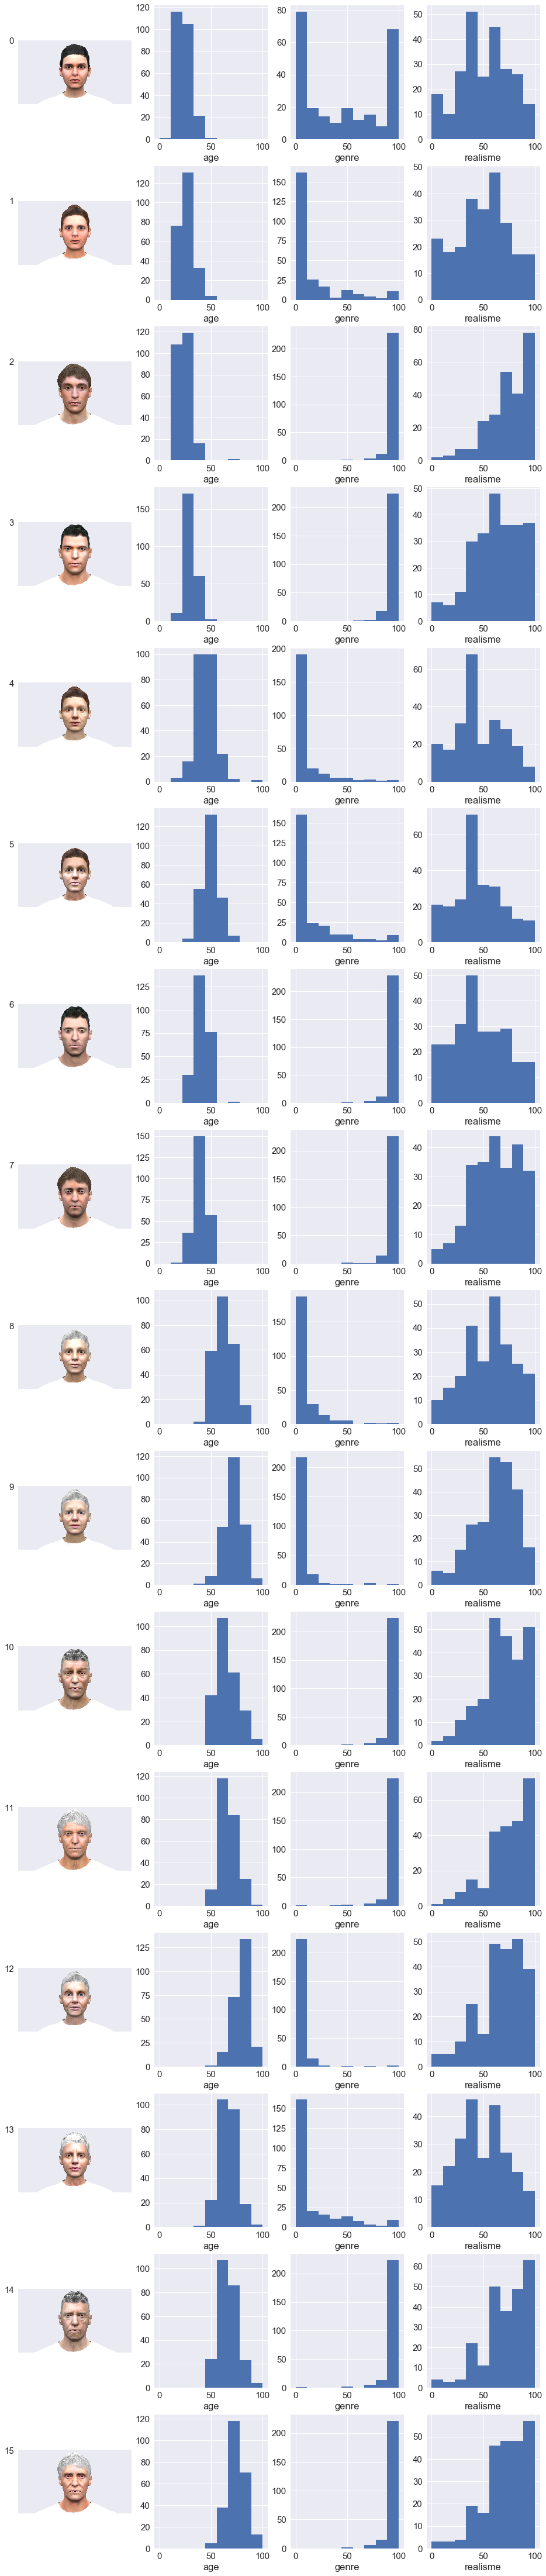

In [30]:
fig = plt.figure(figsize=(16,80))
for idx, avatar in enumerate(avatars[:]):
    plt.subplot(num_avatar, 4, 4*idx+1)
    img=mpimg.imread(r'static\images\bloc1\{}.png'.format(avatar))
    imgplot = plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([avatar-1])
    
    plt.subplot(num_avatar, 4, 4*idx+2)
    df[df.avatar==avatar].age.hist(bins=np.linspace(0, 100, 10))
    plt.xlabel('age')

    
    plt.subplot(num_avatar, 4, 4*idx+3)
    df[df.avatar==avatar].genre.hist(bins=np.linspace(0, 100, 10))
    plt.xlabel('genre')

    plt.subplot(num_avatar, 4, 4*idx+4)
    df[df.avatar==avatar].realisme.hist(bins=np.linspace(0, 100, 10))
    plt.xlabel('realisme')
plt.savefig('Avatar Histogramme.png', dpi=120)
plt.show()

## difference between men and women

In [49]:
df[df.male].age

0     30.0
1     16.0
2     69.0
3     60.0
4     31.0
5     55.0
6     19.0
7     75.0
8      NaN
9      NaN
10     NaN
11    75.0
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22    70.0
23     NaN
24     NaN
25     NaN
26    15.0
27    22.0
28    23.0
29    65.0
30    40.0
31    60.0
32    55.0
33    45.0
34    25.0
35    45.0
36    75.0
37    70.0
38    45.0
39    39.0
40    55.0
41    25.0
42    31.0
43     NaN
44    20.0
45     NaN
46     NaN
47     NaN
48     NaN
49     NaN
50     NaN
51     NaN
52     NaN
53     NaN
54     NaN
55    32.0
56     NaN
57     NaN
58     NaN
59     NaN
60     NaN
61    65.0
62    33.0
63    17.0
0     50.0
1     55.0
2     35.0
3     65.0
4     60.0
5     15.0
6     60.0
7     60.0
8      NaN
9      NaN
10     NaN
11    40.0
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22    45.0
23     NaN
24     NaN
25     NaN
26    30.0

In [50]:
df[['age', 'genre', 'realisme', 'male']].groupby('male').describe()
print(scipy.stats.ttest_ind(df[df.male].age.dropna(), df[~df.male].age.dropna()))

Ttest_indResult(statistic=-1.8593915399993903, pvalue=0.06304689511157988)


## Influence of age of participant

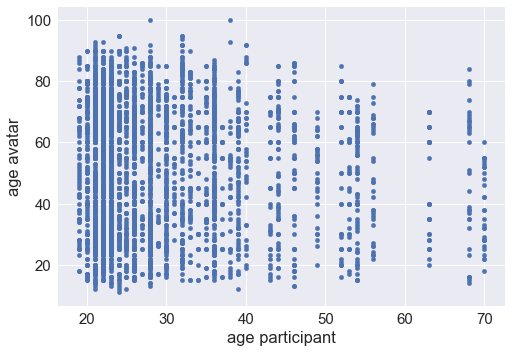

In [9]:
df.plot.scatter('age_participant', 'age')

plt.ylabel('age avatar')
plt.xlabel('age participant')
plt.show()

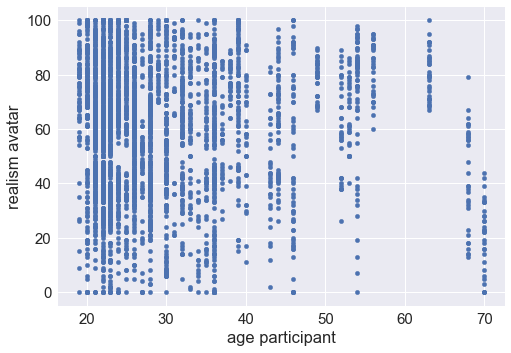

In [10]:
df.plot.scatter('age_participant', 'realisme')
plt.ylabel('realism avatar')
plt.xlabel('age participant')
plt.show()

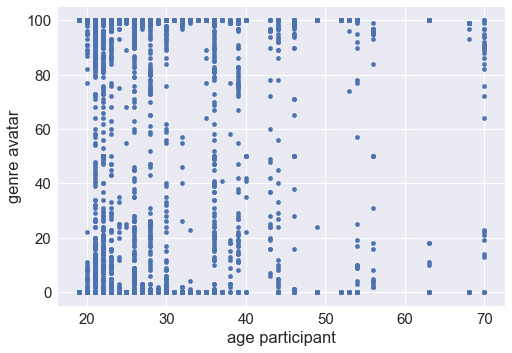

In [11]:
df.plot.scatter('age_participant', 'genre')
plt.ylabel('genre avatar')
plt.xlabel('age participant')
plt.show()

# Bayesian analysis

In [12]:
age_obs_data = np.zeros((num_avatar, num_participant, 2)) * np.nan
for idx, avatar in enumerate(avatars):
    for jdx, par in enumerate(participants):
        age_obs_data[idx, jdx, :] = df[(df.participant==par) & (df.avatar==avatar) & df.age_trial].age.values
        
genre_obs_data = np.zeros((num_avatar, num_participant, 2)) * np.nan
for idx, avatar in enumerate(avatars):
    for jdx, par in enumerate(participants):
        genre_obs_data[idx, jdx, :] = df[(df.participant==par) & (df.avatar==avatar) & df.age_trial].genre.values
        
realisme_obs_data = np.zeros((num_avatar, num_participant, 2)) * np.nan
for idx, avatar in enumerate(avatars):
    for jdx, par in enumerate(participants):
        realisme_obs_data[idx, jdx, :] = df[(df.participant==par) & (df.avatar==avatar) & df.realism_trial].realisme.values[:2]
        
genre_obs = np.clip(genre_obs_data.reshape((num_avatar, -1))/100, 0.01, 0.99) # Clinping genre information to fit a beta distribution

## Simple model

### Age

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_avatars_age, μ_avatars_age]
Sampling 4 chains: 100%|█████████████| 10000/10000 [00:12<00:00, 780.09draws/s]


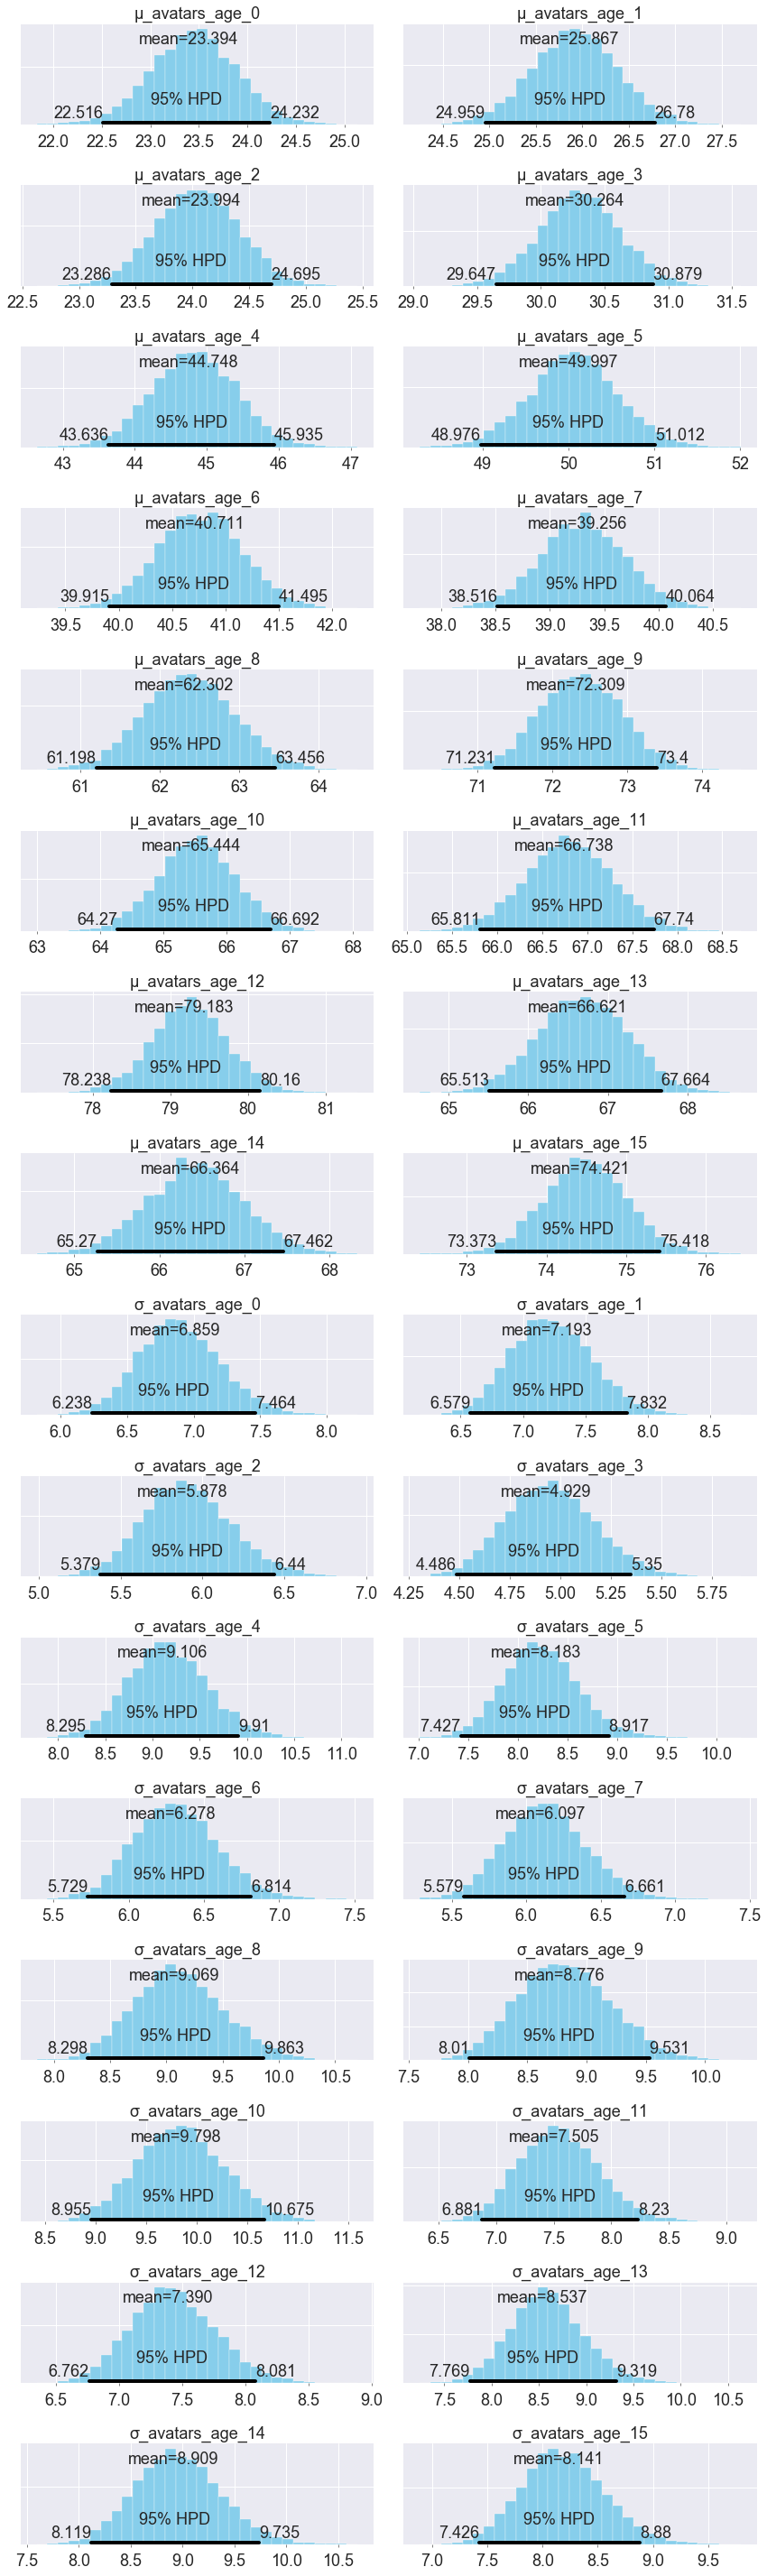

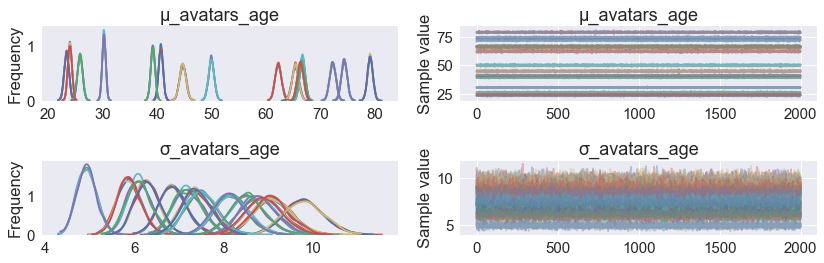

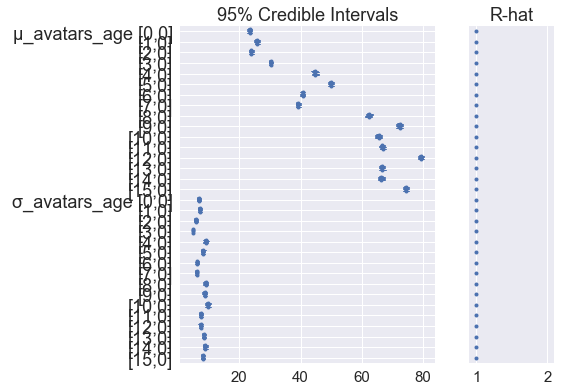

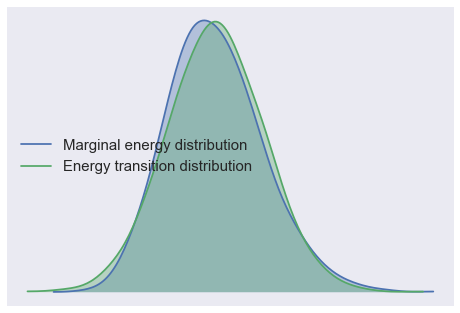

Gelman-Rubin  1.0001708019851188


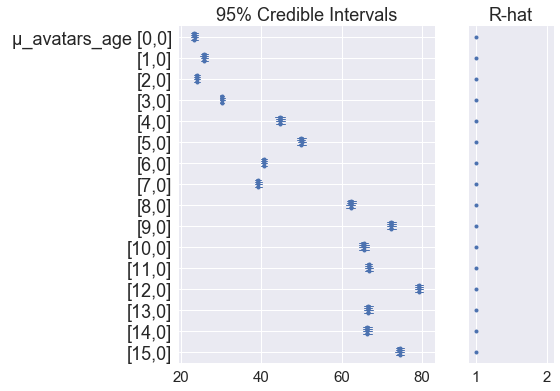

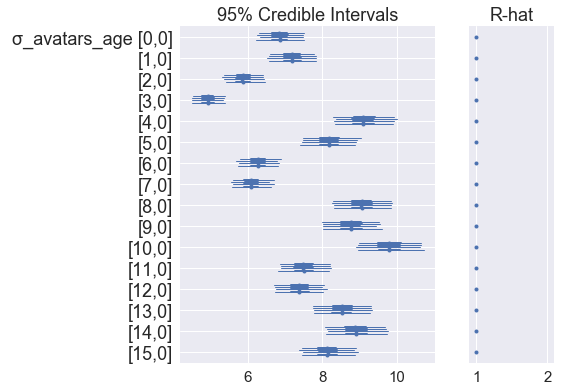

In [13]:
with pm.Model() as model_simple_age:
    # Age
    ## priors
    μ_avatars_age = pm.Uniform('μ_avatars_age', 0, 100, shape=(num_avatar,1))
    σ_avatars_age = pm.HalfCauchy('σ_avatars_age', 25, shape=(num_avatar,1))
    
    ## obsevations
    obs_age = pm.Normal('obs_age', 
                        mu=μ_avatars_age, 
                        sd=σ_avatars_age, 
                        shape=(num_avatar, 1), 
                        observed=age_obs_data.reshape((num_avatar, -1)))
    trace = pm.sample(draws=2000, cores=4)
    
model_to_graphviz(model_simple_age)
summary(trace)
pm.plots.forestplot(trace, varnames=['μ_avatars_age'])
plt.show()
pm.plots.forestplot(trace, varnames=['σ_avatars_age'])
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β_avatars_genre, α_avatars_genre]
Sampling 4 chains: 100%|█████████████| 10000/10000 [00:19<00:00, 503.88draws/s]


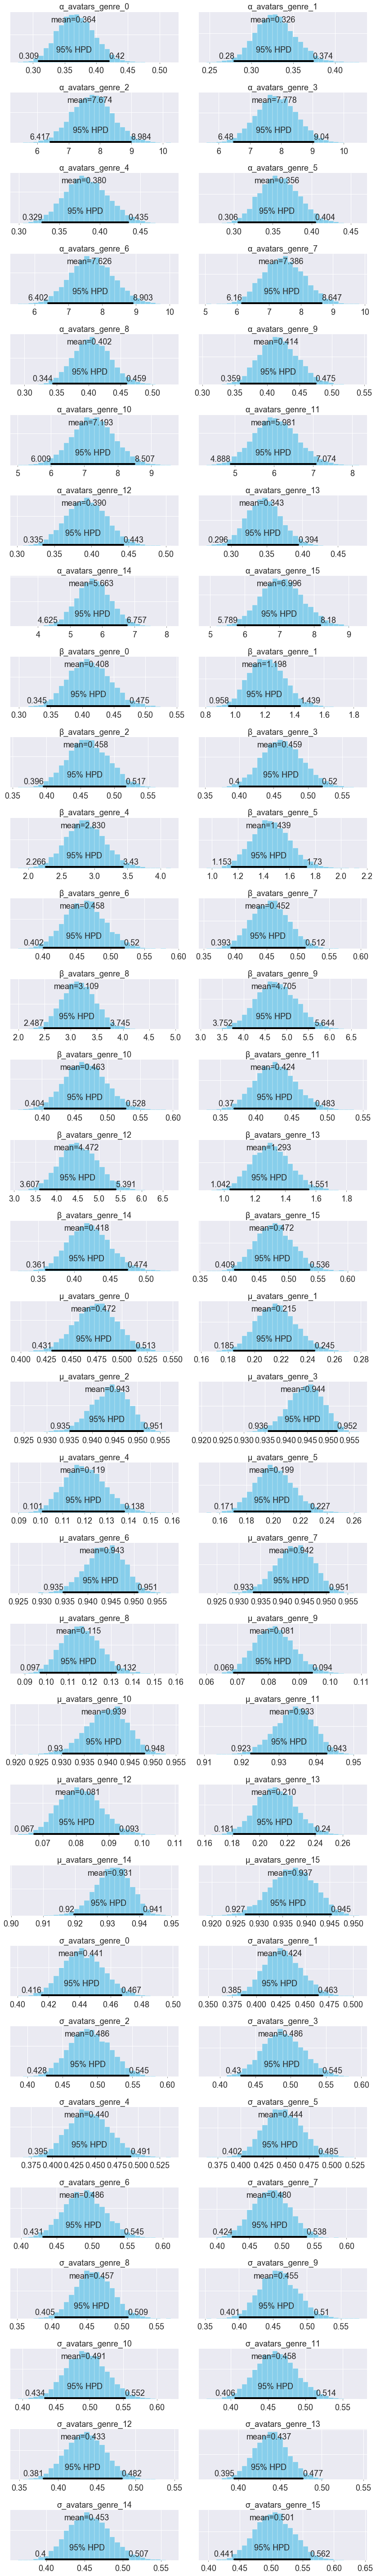

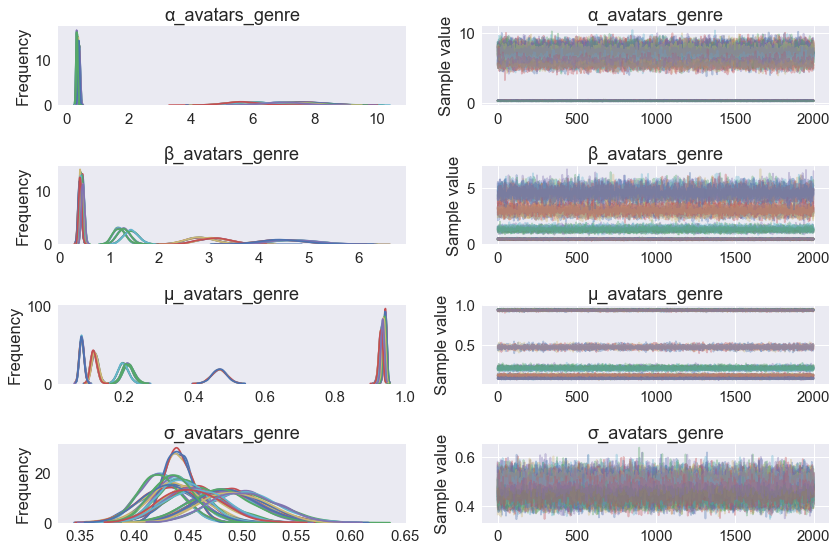

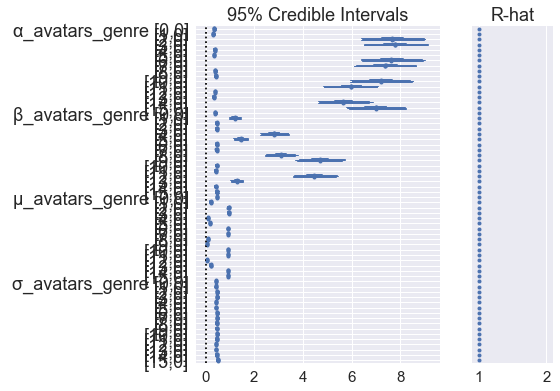

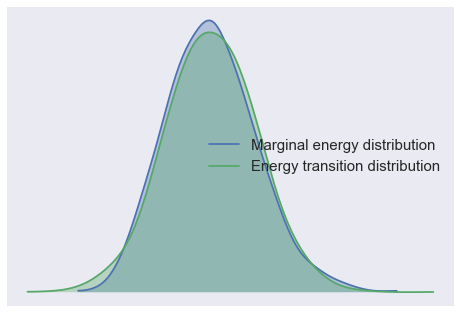

Gelman-Rubin  1.0003439626434965


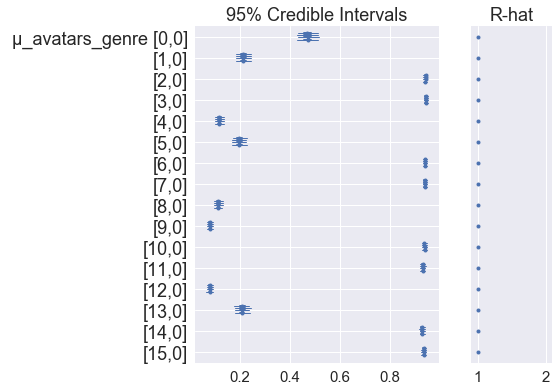

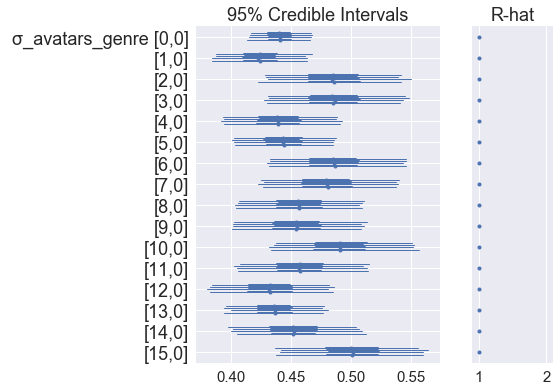

In [14]:
with pm.Model() as model_simple_genre:
    # genre
    ## priors
    α_avatars_genre = pm.HalfNormal('α_avatars_genre', 1, shape=(num_avatar,1))
    β_avatars_genre = pm.HalfNormal('β_avatars_genre', 1, shape=(num_avatar,1))
    
    μ_avatars_genre = pm.Deterministic('μ_avatars_genre', α_avatars_genre/(α_avatars_genre+β_avatars_genre))
    σ_avatars_genre = pm.Deterministic('σ_avatars_genre',
                                       α_avatars_genre*β_avatars_genre/((α_avatars_genre+β_avatars_genre)**2)*(α_avatars_genre+β_avatars_genre+1))
    
    ## obsevations
    obs_genre = pm.Beta('obs_genre',
                          alpha=α_avatars_genre, 
                          beta=β_avatars_genre,
                          shape=(num_avatar, 1),
                          observed=genre_obs)
    trace = pm.sample(draws=2000, cores=4)
    
model_to_graphviz(model_simple_genre)
summary(trace) 
pm.plots.forestplot(trace, varnames=['μ_avatars_genre'])
plt.show()
pm.plots.forestplot(trace, varnames=['σ_avatars_genre'])
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ_avatars_realisme, μ_avatars_realisme]
Sampling 4 chains: 100%|█████████████| 10000/10000 [00:12<00:00, 818.26draws/s]


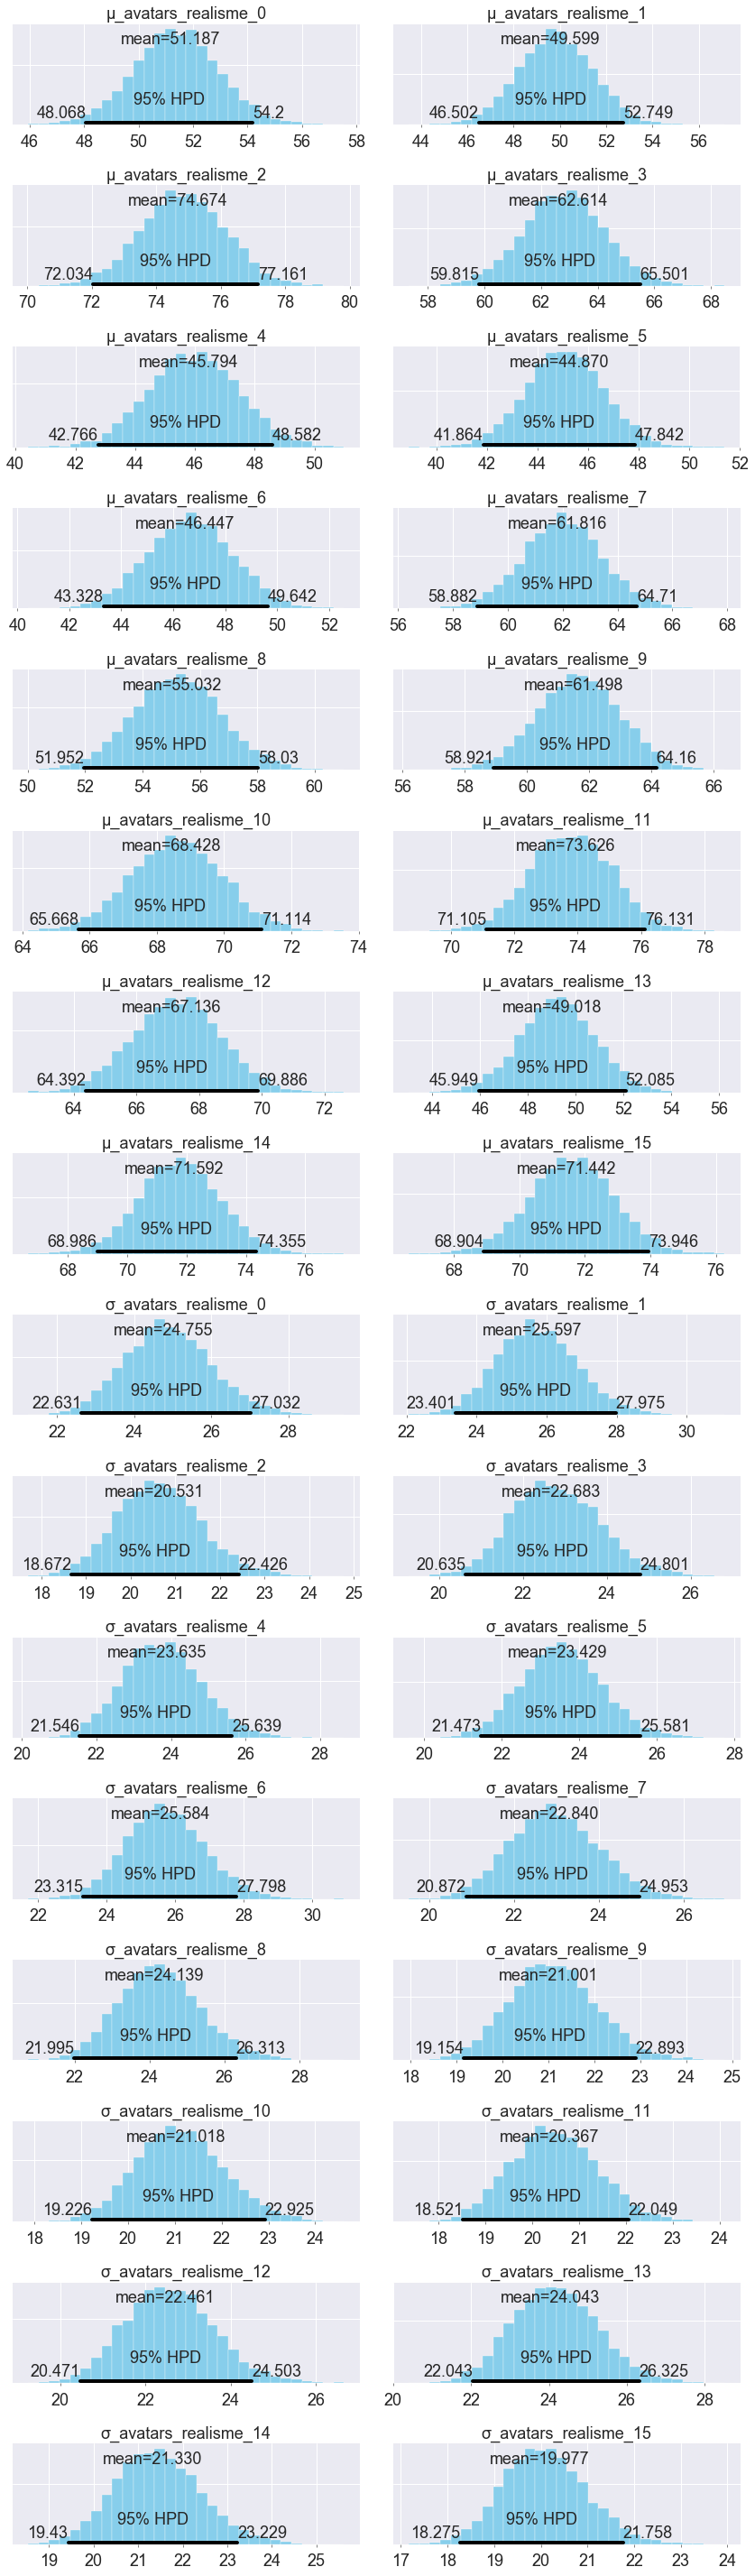

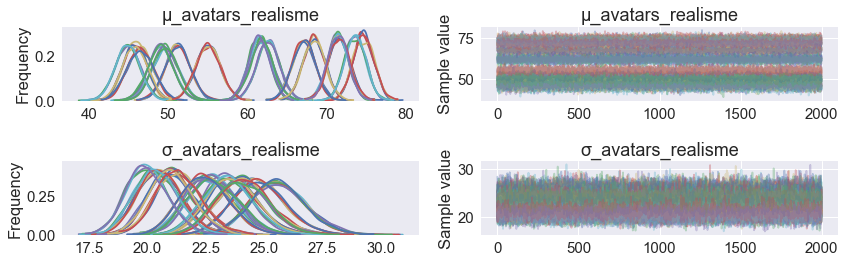

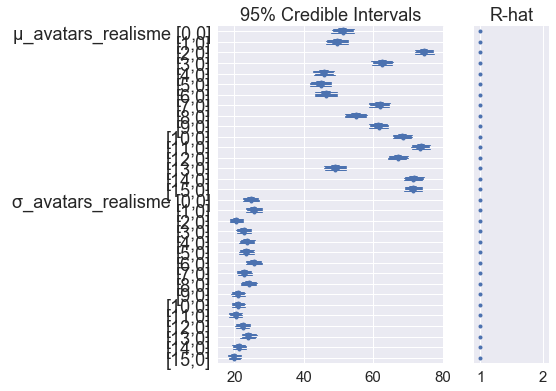

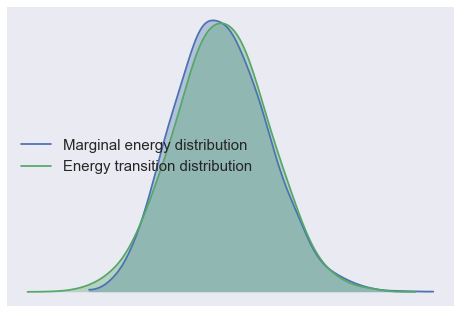

Gelman-Rubin  1.0000267747400047


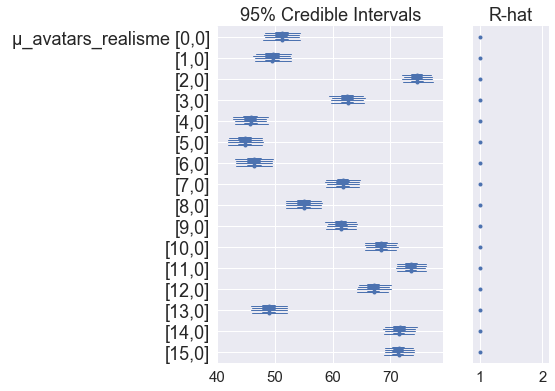

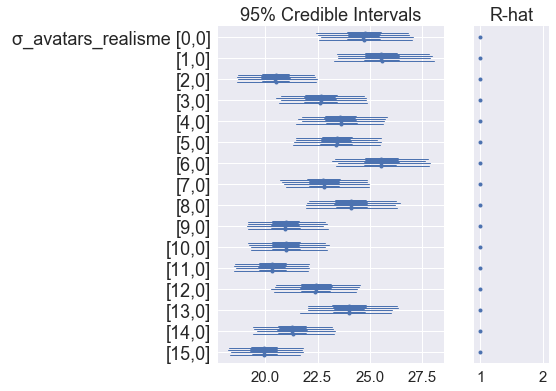

In [15]:
with pm.Model() as model_simple_realisme:
    # realisme
    ## priors
    μ_avatars_realisme = pm.Uniform('μ_avatars_realisme', 0, 100, shape=(num_avatar,1))
    σ_avatars_realisme = pm.HalfCauchy('σ_avatars_realisme', 25, shape=(num_avatar,1))
    
    ## obsevations
    obs_realisme = pm.Normal('obs_realisme', 
                        mu=μ_avatars_realisme, 
                        sd=σ_avatars_realisme, 
                        shape=(num_avatar, 1), 
                        observed=realisme_obs_data.reshape((num_avatar, -1)))
    
    
    trace = pm.sample(draws=2000, cores=4)
    
model_to_graphviz(model_simple_realisme)
summary(trace)
pm.plots.forestplot(trace, varnames=['μ_avatars_realisme'])
plt.show()
pm.plots.forestplot(trace, varnames=['σ_avatars_realisme'])
plt.show()

## Herarchical model

In [ ]:
with pm.Model() as model_herarchical_age:
    # Age
    ## priors
    μ_avatars_age = pm.Uniform('μ_avatars_age', 0, 100, shape=(num_avatar, 1, 1))
    σ_avatars_age = pm.HalfCauchy('σ_avatars_age', 25, shape=(num_avatar, 1, 1))
    
    μ_participant_bias = pm.Normal('μ_participant_bias', mu=0, sd=10, shape=(1, num_participant, 1))
    
    
    obs_age = pm.Normal('obs_age',
                        mu=μ_avatars_age + μ_participant_bias,
                        sd=σ_avatars_age,
                        shape=(num_avatar, num_participant, 1),
                        observed=age_obs_data,
                       )
    
    trace = pm.sample(draws=2000, cores=4)
    
model_to_graphviz(model_simple_genre)
summary(trace) 

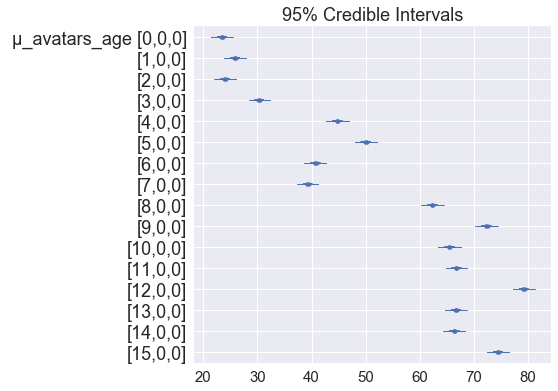

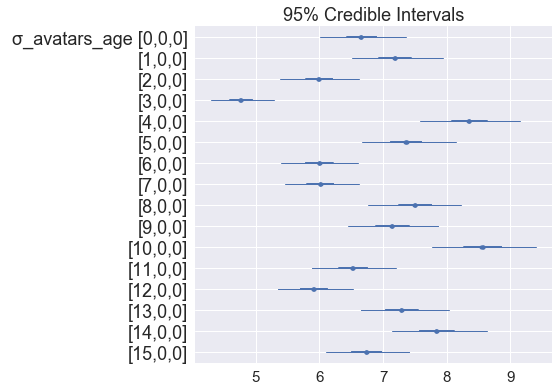

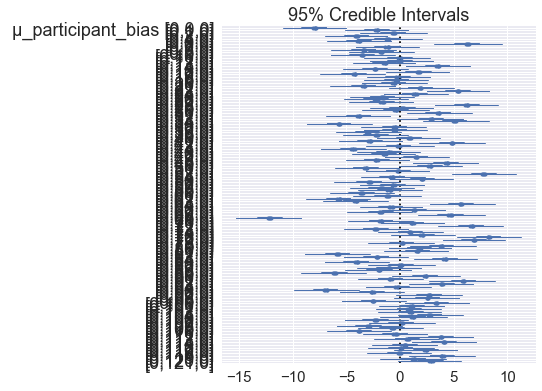

In [34]:
pm.plots.forestplot(trace, varnames=['μ_avatars_age'], rhat=False, chain_spacing=0)
plt.savefig('Age moyen des avatars.png', dpi=220)
plt.show()
pm.plots.forestplot(trace, varnames=['σ_avatars_age'], rhat=False, chain_spacing=0)
plt.savefig('Variance de Age des avatars.png', dpi=220)
plt.show()
pm.plots.forestplot(trace, varnames=['μ_participant_bias'], rhat=False, chain_spacing=0)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
Sampling 4 chains: 100%|████████████| 16000/16000 [00:13<00:00, 1171.22draws/s]


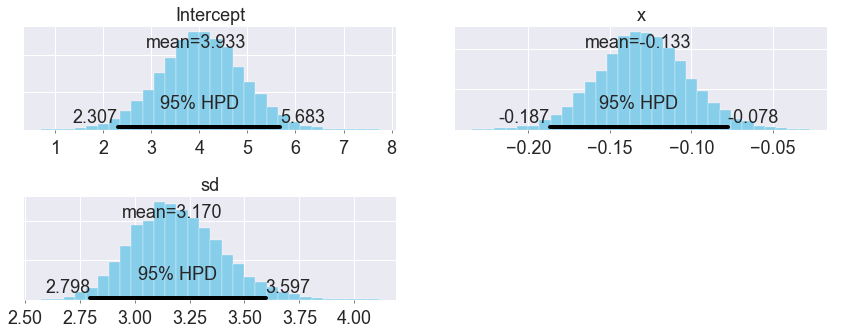

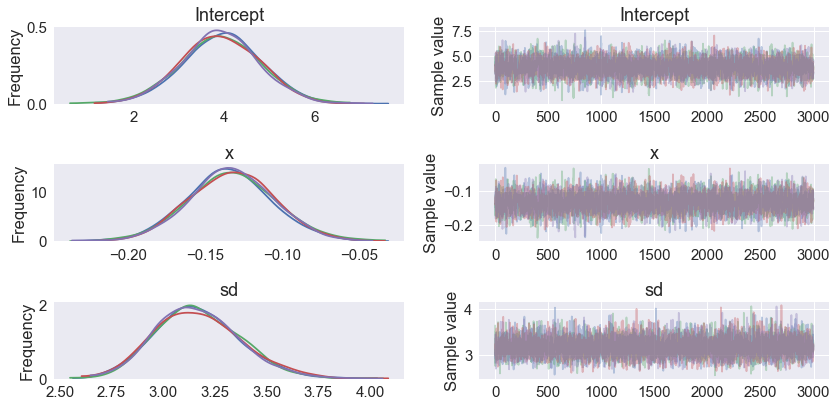

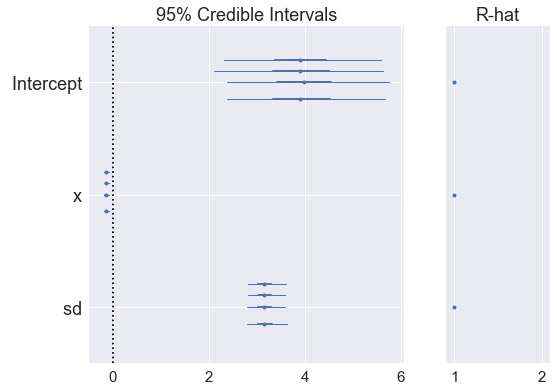

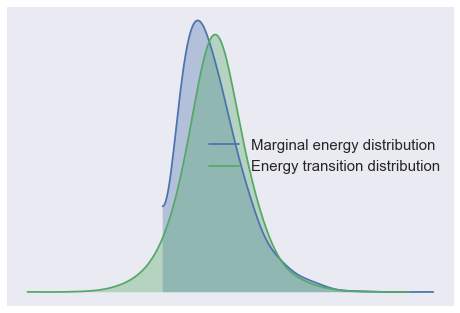

Gelman-Rubin  1.0007604498498825


mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
Intercept  3.932576  0.862525  0.013723  2.307382  5.683239  4306.371168   
x         -0.132966  0.027770  0.000446 -0.186719 -0.077736  4284.682908   
sd         3.169852  0.205834  0.002373  2.797714  3.596786  6596.165476   

               Rhat  
Intercept  1.000542  
x          1.000760  
sd         0.999930

In [17]:
df_age_participant = pd.DataFrame(index=df.groupby('participant').age_participant.mean(), data=np.squeeze(np.mean(trace['μ_participant_bias'],axis=0)), columns=['bias_mean'])
df_age_participant = df_age_participant.reset_index(level=0)


with pm.Model() as age_linear_regression:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    g = glm.GLM.from_formula('bias_mean ~ x', df_age_participant.rename(columns={'age_participant':'x'}))
    trace2 = pm.sample(3000, cores=4, tune=1000) # draw 3000 posterior samples using NUTS sampling
summary(trace2)

<Figure size 576x396 with 0 Axes>

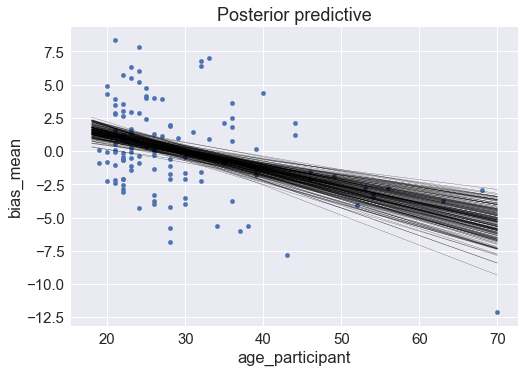

In [18]:
plt.figure()
df_age_participant.plot.scatter('age_participant', 'bias_mean')
pm.plot_posterior_predictive_glm(trace2, eval=np.array([18, 70]), samples=200)


## identifying trolls

Text(0.5,0,'Numéro du participant')

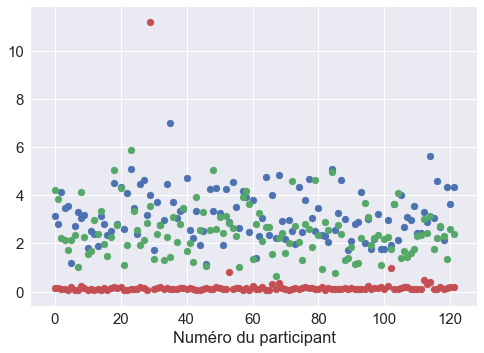

In [53]:
same_avatar_age_std = df.groupby(['participant', 'avatar']).age.std().groupby('participant').mean()
same_avatar_realisme_std = df.groupby(['participant', 'avatar']).realisme.std().groupby('participant').mean()
participant_response_time = df.groupby(['participant']).temps_de_reponse.mean()

plt.scatter(same_avatar_age_std.index, same_avatar_age_std.values / np.std(same_avatar_age_std.values) )
plt.scatter(same_avatar_realisme_std.index, same_avatar_realisme_std.values / np.std(same_avatar_realisme_std.values))
plt.scatter(participant_response_time.index, participant_response_time.values / np.std(participant_response_time.values))

plt.xlabel('Numéro du participant')


Maybe a troll?

In [54]:
df.groupby(['participant', 'avatar']).age.std().groupby('participant').mean().sort_values(ascending=False)

participant
35     8.043340
114    6.452349
84     5.833631
23     5.833631
68     5.568466
64     5.480078
40     5.435883
77     5.391689
27     5.303301
87     5.303301
116    5.259107
54     5.214913
18     5.170718
26     5.126524
34     5.126524
74     4.993942
121    4.993942
119    4.993942
20     4.993942
49     4.949747
52     4.905553
47     4.905553
57     4.817165
2      4.772971
93     4.772971
22     4.728777
66     4.619764
105    4.596194
29     4.596194
58     4.507806
76     4.375223
60     4.375223
36     4.286835
31     4.286835
103    4.198447
120    4.198447
109    4.065864
4      4.065864
55     4.021670
3      3.977476
80     3.977476
24     3.977476
39     3.933281
43     3.844893
48     3.844893
38     3.844893
112    3.800699
7      3.800699
50     3.756505
86     3.756505
98     3.712311
9      3.668116
28     3.668116
14     3.623922
0      3.623922
107    3.579728
115    3.535534
37     3.535534
8      3.535534
78     3.491340
63     3.491340
95     3.447

In [57]:
participant_response_time.sort_values(ascending=False)

participant
29     1185.437500
102     102.765625
53       88.031250
112      51.578125
114      43.234375
68       38.078125
113      33.984375
66       31.890625
101      27.093750
95       25.921875
60       25.875000
8        24.859375
99       22.562500
107      21.718750
120      21.671875
49       21.281250
63       20.796875
121      20.734375
106      20.359375
26       20.140625
117      19.890625
81       19.843750
76       19.125000
5        19.046875
20       18.750000
18       18.687500
32       18.593750
15       18.484375
50       18.343750
19       18.250000
46       18.062500
34       17.781250
39       17.750000
119      17.125000
41       16.953125
55       16.906250
1        16.750000
69       16.390625
88       16.312500
56       16.234375
78       16.046875
9        15.984375
77       15.968750
98       15.843750
0        15.734375
97       15.671875
38       15.640625
31       15.531250
75       15.468750
105      15.453125
83       15.343750
90       14.953125
